# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Требуется построить модель для определения стоимости.

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

**План работы:**
- загрузить данные
- проанализировать данные
- обучить разные модели с различными гиперпараметрами
- проверить данные на тестовой выборке

## Подготовка данных

### Загрузка данных

Установим требуемые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from category_encoders import MEstimateEncoder, OrdinalEncoder

Загрузим файл с данными

In [ ]:
df = pd.read_csv('/datasets/autos.csv')

Выведем датасет на экран, посмотрим общую информацию, проверим на пропуски и дубликаты

In [ ]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [ ]:
df.duplicated().sum()

4

Построим гистограммы для числовых столбцов

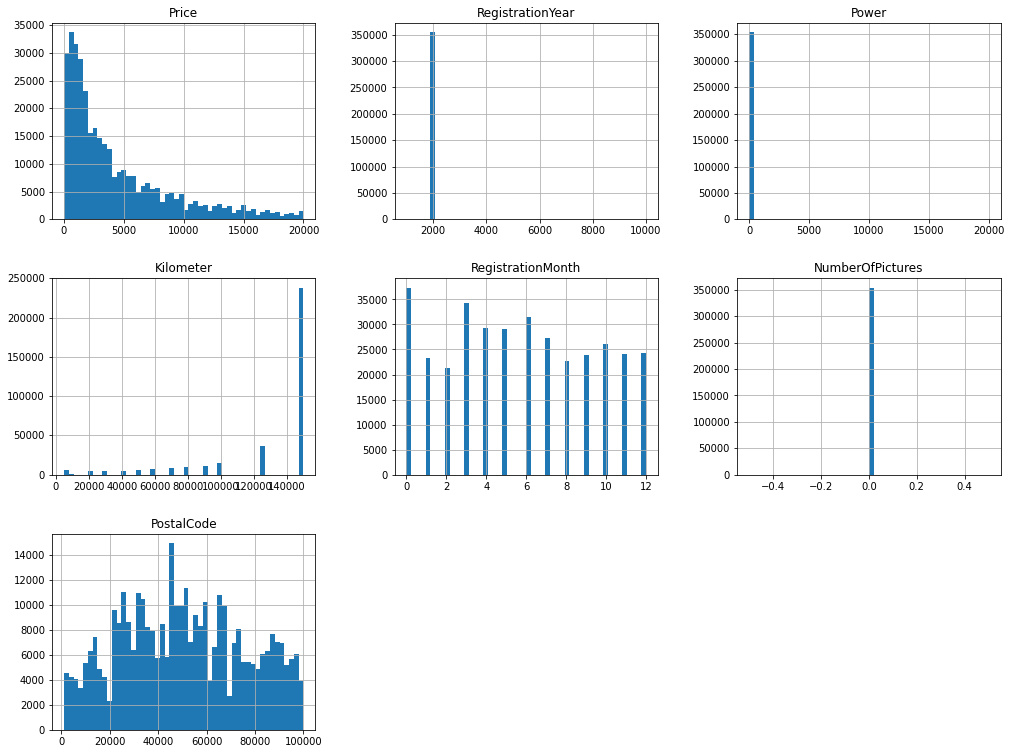

In [ ]:
df.hist(figsize = (17,13), bins=50);

### Предобработка данных

Заменим названия столбцов, приведем к змеиному стилю.

In [ ]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']

In [ ]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Удалим полные дубликаты из датафрейма

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

0

Обработаем пропуски в столбцах:

- gearbox
- fuel_type
- repaired
- model
- vehicle_type

Проверим какие уникальные значения есть в столбцах

In [ ]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [ ]:
df['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [ ]:
df['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [ ]:
df['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [ ]:
df['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

В столбце repaired заменим пропуски на значение no, исходя из предположения что отсутствие информации о ремонте, означает что он не производился.

В остальных столбцах заменим пропуски значением other.

In [ ]:
df['repaired'].fillna('no', inplace=True)
df[['model', 'vehicle_type', 'gearbox', 'fuel_type']]= df[['model', 'vehicle_type', 'gearbox', 'fuel_type']].fillna('other')

In [ ]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

### Исследовательский анализ данных

Проверим столбцы с числовыми данными на наличие аномальных значений

In [ ]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Выведем гистограммы для столбца с ценой

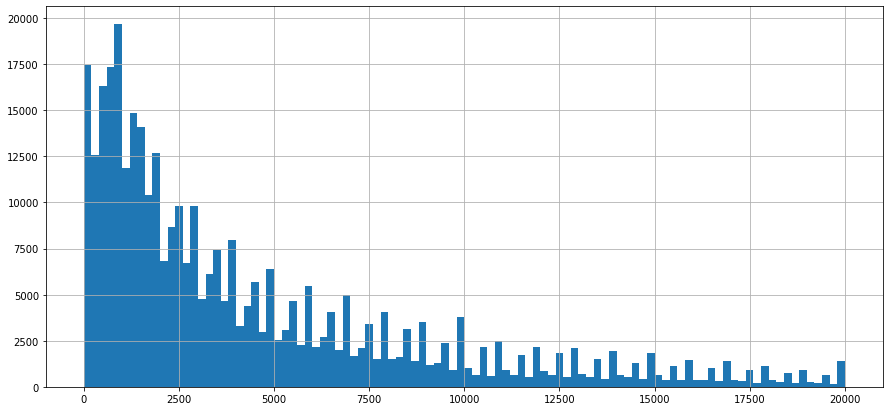

In [ ]:
df['price'].hist(figsize = (15,7), bins=100);

Встречается большое количество значений около нуля. Удалим строки с ценой менее 50 евро.

In [ ]:
df = df.query('price>=50')

Выведем гистограмму для столбца с годом регистрации автомобиля.

Для более детального анализа, выведем гистограммы с двумя периодами.

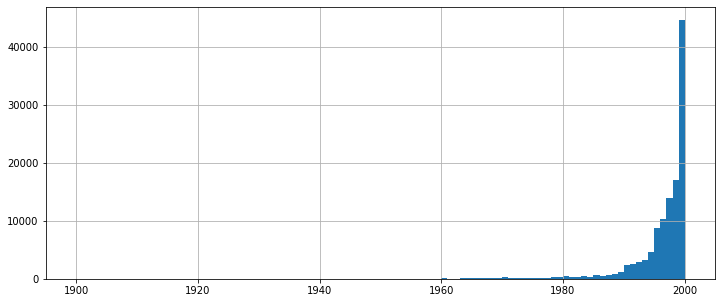

In [ ]:
df['registration_year'].hist(figsize = (12,5), bins=100, range =(1900,2000));

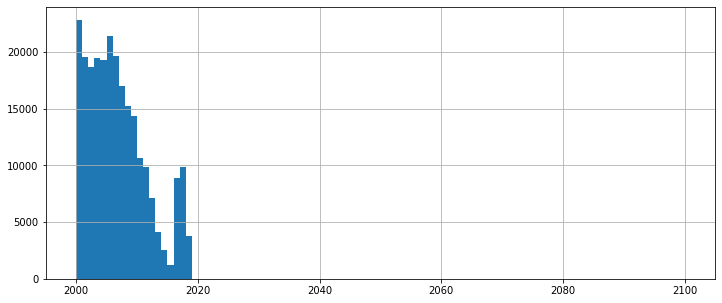

In [ ]:
df['registration_year'].hist(figsize = (12,5), bins=100, range =(2000,2100));

В столбце встречаются как значения с очень давним сроком регистрации автомобиля, так и значения превышающие 2016 год, в котором формировались данные.

Удалим данные превышающие 2017 год и ранее 50 лет.

In [ ]:
df = df.query('registration_year>1966')

In [ ]:
df = df.query('registration_year<2017')

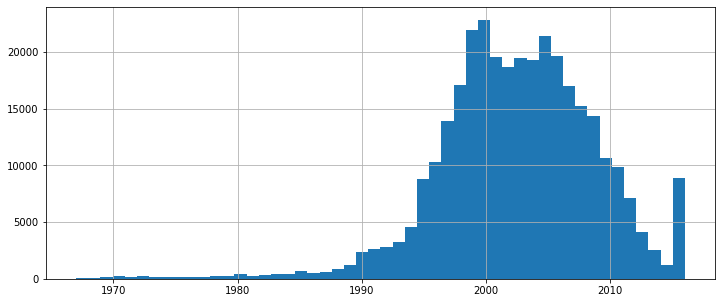

In [ ]:
df['registration_year'].hist(figsize = (12,5), bins=50);

Построим гистограмму для столбца с мощьностью автомобилей

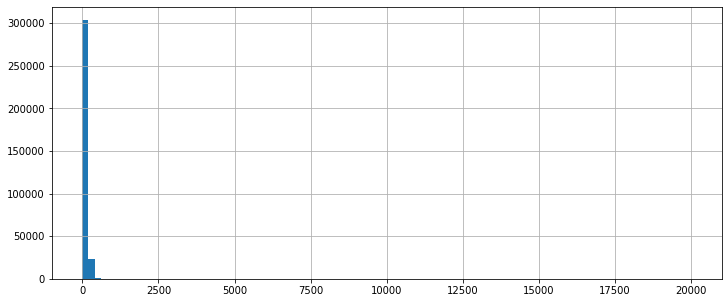

In [ ]:
df['power'].hist(figsize = (12,5), bins=100);

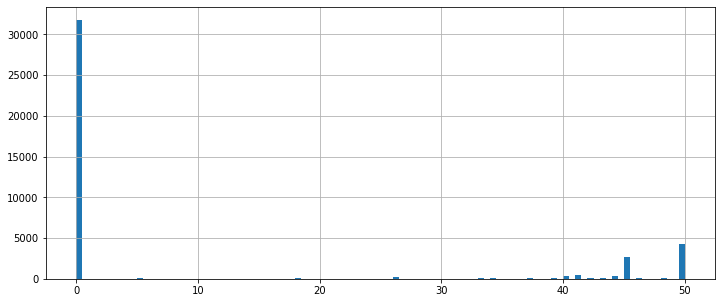

In [ ]:
df['power'].hist(figsize = (12,5), bins=100, range =(0,50));

Из гистограмм видно, что есть нулевые значения, и значения превышающие 2000 л.с.(максимальная мощьность на данный момент).

Нулевые значения заменим на медианное значение мощности для модели автомобиля, а строки с очень большими значениями удалим из датасета.

In [ ]:
# с помощью цикла присвоим значениям в колонке power медианное значение
# исходя из значений столбца model
for a in df['model'].unique():
     df.loc[(df['model'] == a) & (df['power'] == 0), 'power'] = \
     df.loc[(df['model'] == a), 'power'].median()

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Использование циклов в Пандасе жутко неоптимально. Причина в том, что датфреймы, как правило, имеют очень "большие размеры" (очень много строк и очень много столбцов). Итерация по ним (строкам/столбцам ... и далее выполнение для каждой строки/столбца какой-либо операции) соответственно занимает много времени (%%time позволяет узнать время выполнения конкретной ячейки - посмотри в Интернете как использовать эту "магическую" команду).
    
Какой выход из ситуации, если он есть? Да, он есть и таков: необходимо использовать векторные операции. То есть перестраивать логику работы с использования циклов на использование операций, которые применяются **сразу** ко всем строкам датафрейма/ко всем его столбцам.
    
Конкретно в твоем случае, код твоего цикла можно заменить на такой (**это псевдокод**):
    
    df['power'] = df['power'].fillna(df.groupby(by=['model'])['power'].transform('median'))
    
p.s. этот (и прочие советы по группировке данных в Пандасе) находятся на этом ресурсе: https://dfedorov.spb.ru/pandas
ОЧЕНЬ! рекомендую этот ресурс. Я сам его частый посетитель.
</div>

In [ ]:
df = df.query('power<2000')

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Да, верно: низший и высший пороги мощности обсуждаемы, но для целей нашего учебного проекта достаточно того, что ты видишь проблему выбросов и необходимым способом её обрабатываешь.
</div>

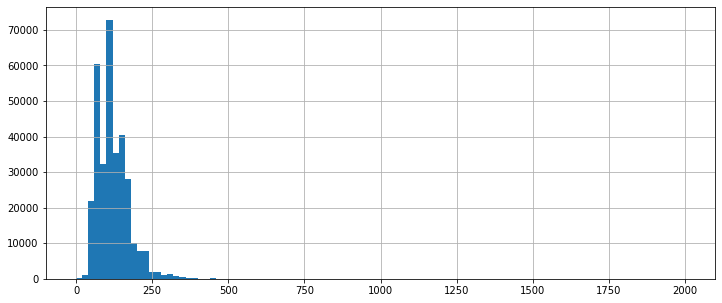

In [ ]:
df['power'].hist(figsize = (12,5), bins=100, );

Построим гистограммы для столбца с пробегом автомобилей

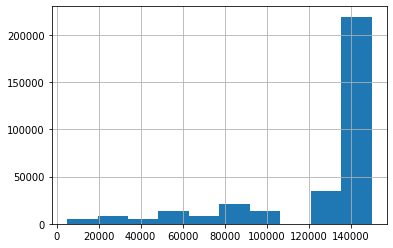

In [ ]:
df['kilometer'].hist();

Аномальных значений не выявлено

### Подготовка данных для обучения моделей

В датасете присутствуют признаки не оказывающие влияние на цену автомобиля: дата скачивания анкеты из базы, месяц регистрации автомобиля,  количество фотографий автомобиля(везде значение 0), почтовый индекс владельца анкеты,  дата последней активности пользователя.

При этом из столбца с датой создания анкеты извлечем год и месяц, так как автомобильный рынок имеет фактор сезонности, что влияет на спрос и стоимость автомобилей.

Удалим столбцы которые не оказывают влияние на цену автомобиля.
- date_crawled
- registration_month
- number_of_pictures
- postal_code
- last_seen

In [ ]:
df = df.drop(['date_crawled', 'registration_month', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

In [ ]:
# преобразуем столбец date_created в формат datetime

df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
# создадим в датасете столбцы с годом и месяцем создания анкеты

df['month_created'] = df['date_created'].dt.month
df['year_created'] = df['date_created'].dt.year

In [ ]:
# изменим тип данных в столбце registration_year

df['registration_year'] = df['registration_year'].astype(int)

In [ ]:
# удалим столбец date_created, год и месяц мы уже получили

df = df.drop(['date_created'], axis=1)

Выведем датафрейм на эркан, еще раз посмотрим общую информацию о данных

In [ ]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,month_created,year_created
0,480,other,1993,manual,100.0,golf,150000,petrol,volkswagen,no,3,2016
1,18300,coupe,2011,manual,190.0,other,125000,gasoline,audi,yes,3,2016
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,no,3,2016
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,3,2016
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,3,2016


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327321 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              327321 non-null  int64  
 1   vehicle_type       327321 non-null  object 
 2   registration_year  327321 non-null  int64  
 3   gearbox            327321 non-null  object 
 4   power              327321 non-null  float64
 5   model              327321 non-null  object 
 6   kilometer          327321 non-null  int64  
 7   fuel_type          327321 non-null  object 
 8   brand              327321 non-null  object 
 9   repaired           327321 non-null  object 
 10  month_created      327321 non-null  int64  
 11  year_created       327321 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 32.5+ MB


Все требуемые столбцы присутствуют, данные подготовлены

Разделим датасет на обучающую, валидационную и тестовую выборки.

In [ ]:
train, validate, test = np.split(df.sample(frac=1, random_state=12345), [int(.6*len(df)), int(.8*len(df))])

Выделим целевой признак и признаки для обучения моделей.

In [ ]:
features_train = train.drop(['price'], axis=1)
target_train = train['price']

features_valid = validate.drop(['price'], axis=1)
target_valid = validate['price']

features_test = test.drop(['price'], axis=1)
target_test = test['price']

Преобразуем столбцы с категориальными признаками с помощью метода  OrdinalEncoder для столбцов vehicle_type, gearbox, fuel_type, repaired, так как данный метод не создает дополнительных признаков, модель будет обучаться быстрее.

Для столбцов model и brand применим MEstimateEncoder, так как данные в столбцах не имеют между собой порядковой связи и количество значений в них превышает 15.

In [ ]:
# создадим копии признаков для каждой выборки

train_encoder = features_train.copy()
test_encoder = features_test.copy()
valid_encoder = features_valid.copy()

In [ ]:
# создадим список столдцов с категориальными признаками

col_oe =  ['vehicle_type', 'gearbox','fuel_type', 'repaired']
col_me = ['model', 'brand']
cat_features =  ['vehicle_type', 'gearbox','fuel_type', 'repaired', 'model', 'brand']

In [ ]:
pd.options.mode.chained_assignment = None
# используем метод OrdinalEncoder
encoder = OrdinalEncoder()
encoder.fit(train_encoder[col_oe])
# применим к обучающей, валидационной и тестовой выборке
train_encoder[col_oe] = encoder.transform(train_encoder[col_oe])
test_encoder[col_oe] = encoder.transform(test_encoder[col_oe])
valid_encoder[col_oe] = encoder.transform(valid_encoder[col_oe])

In [ ]:
pd.options.mode.chained_assignment = None
# используем метод MEstimateEncoder

mencoder = encoder = MEstimateEncoder(cols=col_me, handle_unknown='value', handle_missing = 'value')
mencoder.fit(train_encoder, target_train)

# применим к обучающей, валидационной и тестовой выборке
train_encoder = mencoder.transform(train_encoder)
test_encoder = mencoder.transform(test_encoder)
valid_encoder = mencoder.transform(valid_encoder)

In [ ]:
train_encoder.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,month_created,year_created
236251,1,2000,1,170.0,5224.885779,150000,1,6408.146653,1,3,2016
124801,2,2006,1,68.0,3205.234884,150000,2,3207.100617,1,3,2016
145304,2,1996,2,75.0,2641.644658,150000,1,4596.997941,1,3,2016
34509,3,2002,2,133.0,4448.673379,150000,3,3606.238041,1,3,2016
284437,4,1994,1,68.0,7085.704973,150000,2,4596.997941,1,4,2016


В проекте используем модели RandomForestRegressor, LGBMRegressor и CatBoostRegressor, для данных моделей проводить маштабирование числовых признаков не требуется.

### Вывод

На этапе подготовки данных были выявлены пропуски, дубликаты и аномальные значения в данных.

В столбцах gearbox, fuel_type, repaired, model, vehicle_type были обработаны пропущенные значения.

Удалены полные дубликаты в данных.

В столбцах price, registration_year, power были обработаны аномальные значения.

Из датафрейма удалими признаки не оказывающие влияние на стоимость автомобилей.

Разделили датафрейм на обучающую и тестовую выборки.

Преобразовали категориальные признаки техникой  OrdinalEncoder и MEstimateEncoder.

## Обучение моделей

Для обучения выберем три модели RandomForestRegressor, LGBMRegressor и CatBoostRegressor.

Подберем для них лучшие гиперпараметры, сохраним лучшие модели, оценим качество с помощью метрики RMSE.

Метрика RMSE - она представляет собой стандартное отклонение выборки различий между предсказанными и наблюдаемыми значениями и хорошо подходит для оценки точности прогноза.

### Подбор гиперпараметров

#### RandomForest

In [ ]:
%%time

model_random = RandomForestRegressor()
parametrs = { 'n_estimators': range (50, 100, 10),
              'max_depth': range (1,13, 2),
              'random_state':[12345]}

grid = GridSearchCV(model_random, parametrs, cv=3,scoring='neg_root_mean_squared_error')
model_grid = grid.fit(train_encoder, target_train)

print('Параметры лучшей модели:', model_grid.best_params_)
print('RMSE:', model_grid.best_score_)

Параметры лучшей модели: {'max_depth': 11, 'n_estimators': 90, 'random_state': 12345}
RMSE: -1786.2395582045729
CPU times: user 11min 53s, sys: 981 ms, total: 11min 54s
Wall time: 11min 55s


#### CatBoost

In [ ]:
%%time

model_catboost = CatBoostRegressor()
parametrs = { 'iterations': range (50, 100, 10),
              'depth': range (1,13, 2),
              'random_state':[12345]}

grid = GridSearchCV(model_catboost, parametrs, cv=3,scoring='neg_root_mean_squared_error')
model_grid = grid.fit(features_train, target_train, cat_features = cat_features, verbose = False)

print('Параметры лучшей модели:', model_grid.best_params_)
print('RMSE:', model_grid.best_score_)

Параметры лучшей модели: {'depth': 11, 'iterations': 90, 'random_state': 12345}
RMSE: -1638.973714979041
CPU times: user 6min 5s, sys: 3.19 s, total: 6min 8s
Wall time: 7min 19s


#### LGBM

In [ ]:
%%time

model_lgbm = LGBMRegressor()
parametrs = { 'n_estimators': range (50, 100, 10),
              'max_depth': range (1,13, 2),
              'random_state':[12345]}

grid = GridSearchCV(model_lgbm, parametrs, cv=3,scoring='neg_root_mean_squared_error')
model_grid = grid.fit(train_encoder, target_train)

print('Параметры лучшей модели:', model_grid.best_params_)
print('RMSE:', model_grid.best_score_)

Параметры лучшей модели: {'max_depth': 11, 'n_estimators': 90, 'random_state': 12345}
RMSE: -1703.738601376646
CPU times: user 20min 53s, sys: 11.4 s, total: 21min 4s
Wall time: 21min 15s


### Обучение и предсказания моделей

Для каждой модели сохраним лучшие гиперпараметры, измерим время обучения и предсказания, сделаем расчет метрики RMSE на валидационной выборке.

#### RandomForest

In [ ]:
#сохрамим лучшую модель
model_random =RandomForestRegressor(n_estimators=90, max_depth=11, random_state=12345)

In [ ]:
%%time
# обучим модель
model_random.fit(train_encoder, target_train)

CPU times: user 28.2 s, sys: 56.6 ms, total: 28.3 s
Wall time: 28.5 s


RandomForestRegressor(max_depth=11, n_estimators=90, random_state=12345)

In [ ]:
%%time
# получим предсказания на валидационной выборке
predict_valid_forest = model_random.predict(valid_encoder)

CPU times: user 621 ms, sys: 72 µs, total: 621 ms
Wall time: 626 ms


In [ ]:
# получим значение RMSE
mean_squared_error(target_valid, predict_valid_forest, squared=False)

1774.6977739946592

#### CatBoost

In [ ]:
model_catboost =CatBoostRegressor(iterations=90, depth=11, random_state=12345)

In [ ]:
%%time
# обучим модель
model_catboost.fit(features_train, target_train, cat_features = cat_features, verbose = False)

CPU times: user 13.4 s, sys: 111 ms, total: 13.6 s
Wall time: 14.4 s


In [ ]:
%%time
# получим предсказания на валидационной выборке
predict_valid_catboost = model_catboost.predict(features_valid)

CPU times: user 116 ms, sys: 25 µs, total: 116 ms
Wall time: 115 ms


In [ ]:
# получим значение RMSE
mean_squared_error(target_valid, predict_valid_catboost, squared=False)

1614.0268078157096

#### LGBM

In [ ]:
model_lgbm =LGBMRegressor(iterations=90, max_depth=11, random_state=12345)

In [ ]:
%%time
# обучим модель
model_lgbm.fit(train_encoder, target_train)

CPU times: user 23.1 s, sys: 188 ms, total: 23.3 s
Wall time: 23.4 s


LGBMRegressor(iterations=90, max_depth=11, random_state=12345)

In [ ]:
%%time
# получим предсказания на валидационной выборке
predict_valid_lgbm = model_lgbm.predict(valid_encoder)

CPU times: user 560 ms, sys: 6.8 ms, total: 567 ms
Wall time: 590 ms


In [ ]:
# получим значение RMSE
mean_squared_error(target_valid, predict_valid_lgbm, squared=False)

1680.3664065563069

Оценим результаты и выберем лучшую модель

## Анализ моделей

Соберем данные о качестве, времени обучения и предсказания для каждой модели в одну таблицу.

In [ ]:
models = [[1774.69, 1614.02, 1680.36],
          [28.2, 13.4, 23.1],
          [0.621, 0.116, 0.560]]

table = pd.DataFrame(models, index=['RMSE', 'Время обучения, с', 'Время предсказания, с'],
                     columns=['RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor'])
table

,RandomForestRegressor,CatBoostRegressor,LGBMRegressor
RMSE,1774.690,1614.020,1680.36
"Время обучения, с",28.200,13.400,23.10
"Время предсказания, с",0.621,0.116,0.56


Самое низкое значение метрики RMSE у модели CatBoost и составляет 1614,02.

Самое маленькое время обучения у модели CatBoost - 13.4 с.

Самое маленькое время предсказания у модели CatBoost - 0,116 с.

Модель CatBoost показала лучшее значение качества, времени предсказания и обучения.

Лучшей моделью исходя из критериев заказчика является CatBoost.

Проверим ее на тестовой выборке.

In [ ]:
predict_valid_catboost = model_catboost.predict(features_test)

In [ ]:
mean_squared_error(target_test, predict_valid_catboost, squared=False)

1607.0722055674519

Значение RMSE на тестовой выборке для модели CatBoost составило 1607.07.

## Вывод

На этапе обработки данных были обработаны пропущенные значения, удалены полные дубликаты, проведена работа над аномальными значениями.

Из датафрейма были удалены признаки не оказывающие влияние на стоимость автомобилей.

Для определения модели соответствующей критериям были выбраны три модели:

- RandomForestRegressor
- LGBMRegressor
- CatBoostRegressor

Самое низкое значение метрики RMSE у модели CatBoost и составляет 1614,02.

Самое маленькое время обучения у модели CatBoost - 13.4 с.

Самое маленькое время предсказания у модели CatBoost - 0,122 с.

Модель CatBoost показала лучшее значение качества, времени предсказания и обучения.

Лучшей моделью исходя из критериев заказчика является CatBoost.

Значение RMSE на тестовой выборке для данной модели составило 1607.07.